In this document I am assuming that the growth and movement of Specialties are at a minimum state such that the dataset reflects minimised cost of assigning a Specialty to a different state as the dataset does not talk about any of the interchanges that a prescription must undergo when prescriptions are made for only within 10 claims in a year.

The Opioid Prescriber Count and NPI Count are important factors for obtaining the right hypothesis for the *** Awareness of Drugs *** for a Specialty within a Knowledge Base. 

The availability of NPIs within a Speciality for a particular State for prescribing proper medications and dosages is also a contributing factor for the evaluation of *** Specialty Factor for Drugs *** .

The influence of specialties is a common criteria for an NPIs designation and is considered to be a factor that is common to all the States. The attribute for a specialty to show whether the NPIs have *** crossed the median value of the claim count *** in their prescriptions, increases the Influence of Specialty for a prescription drug. The list of IQR counts and Median counts have been evaluated within a table called 'specialty_entropy'.

The Cost Function for such a criteria must be minimised, such that there is less cost incurred due to the:

    * Drug awareness,
    * Specialty Availability, and
    * Usage Statistics


```sql
--- Schema for pa_specialty_entropy
CREATE TABLE IF NOT EXISTS `pa_specialty_entropy` (
  `nppes_provider_state` varchar(5) NOT NULL,
  `specialty_description` varchar(128) NOT NULL,
  `drug_count` int(11) NOT NULL,
  `npi_count` int(11) NOT NULL,
  `total_claim_count` int(11) NOT NULL,
  `median_count` int(11) NOT NULL
) ENGINE=InnoDB DEFAULT CHARSET=utf8;
```

```sql
--- Schema for claim_statistics
CREATE TABLE IF NOT EXISTS `pa_claim_statistics` (
  `nppes_provider_state` varchar(5) NOT NULL,
  `specialty_description` varchar(128) NOT NULL,
  `total_claim_count` int(11) NOT NULL,
  `drug_count` int(11) NOT NULL,
  `median_claim` float NOT NULL,
  `median_supply` float NOT NULL
) ENGINE=InnoDB DEFAULT CHARSET=utf8;
```

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import scipy
import sys, os
from sklearn.model_selection import train_test_split

import pymysql
import pickle

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

sys.path.append(os.path.abspath(os.path.dirname('../code/')))

from Plotting import visuals
from sklearn import metrics

In [2]:
from Database import Database, Partition
import CostFunction
from sklearn.linear_model import LinearRegression, SGDClassifier, SGDRegressor

CostFunction.py Not in Command line Mode


*** Gradient Descent Algorithm ***

The gradient desecent algorithm is applied to evaluate the Specialty weight against the relevant parameters. The score is reported and the graph is found to be underfitting.

The Stochastic Gradient Descent Classifier gave good results for the dataset of size 150000, but the Regressor has not been able to fit the curve.

In [16]:
safety_regressor_y = SGDRegressor()
safety_regressor_ya = SGDRegressor()
health_regressor_y = SGDRegressor()
health_regressor_ya = SGDRegressor()

limit = 18446744073709551615 # A 10th fraction of the Full Dataset (1.2 million) is chosen to be as 150,000

partition = Partition('PA')
database = Database(partition)
costfunction = CostFunction.CostFunction(database, safety_regressor_y, 
                safety_regressor_ya, health_regressor_y, health_regressor_ya)

In [16]:
# Fetching the pa_factors
z_safety = costfunction.get_safety_z_cost_function(0, 150000)

In [17]:
X = np.array(z_safety['X'], dtype=np.dtype(np.float64))
y = np.array(z_safety['y'])

In [18]:
(sgdr_X_train, sgdr_X_test, sgdr_y_train, sgdr_y_test, sgdr_y_pred) = costfunction.regression_specialty_weight(X, y)

In [20]:
score = safety_regressor_y.score(sgdr_X_test, sgdr_y_test)

In [21]:
print("Specialty Weight: SGDClassifier Algorithm score has been found to be: 0.330464646465")
print("Specialty Weight: SGDRegressor Algorithm score")
print(score)
print(sgdr_y_pred)

Specialty Weight: SGDClassifier Algorithm score has been found to be: 0.330464646465
Specialty Weight: SGDRegressor Algorithm score
-2.13250093216e+28
[  1.20595118e+19   6.20279788e+18   4.20693702e+19 ...,  -5.90051457e+18
  -4.24730992e+18  -7.41412963e+18]


In [22]:
print("Coefficients / Weights of Features: ")
print(safety_regressor_y.coef_)
print("Intercept term")
print(safety_regressor_y.intercept_)

Coefficients / Weights of Features: 
[ -9.76744080e+08  -1.29180102e+13  -2.77703372e+11  -6.00192564e+10
  -7.13292528e+13   7.45356985e+12  -4.53543993e+13  -6.07524019e+13
  -6.12455015e+11]
Intercept term
[ -1.85408673e+11]


In [23]:
from Plotting import plot_underfitting_overfitting

X_test = [X[idx:50000] for idx in range(0, 50000, 150000)]
y_test = [y[idx:50000] for idx in range(0, 50000, 150000)]

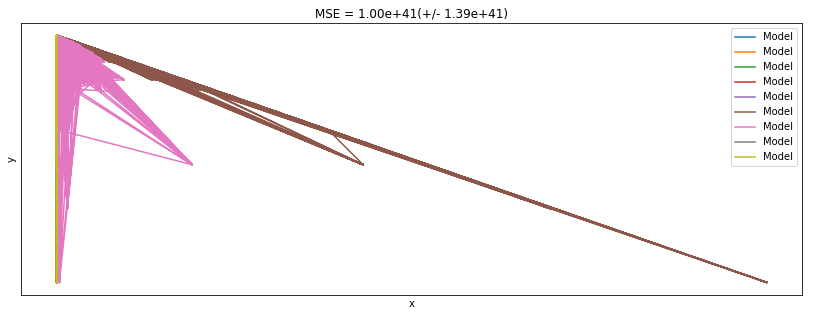

In [24]:
plot_underfitting_overfitting.plot_function(X, y, X_test, y_test)

#### Ensemble Boosting

The True Concepts of Safety involving 'Specialty Weight' and 'Drug Factor Specialty' have been selected for the ensemble boosting regression analysis.

An ensemble boosting method needs to be applied which relates:

    1. Drug Factor for Specialty,
    2. Specialty Factor For Drug, with:
        - Claim per Dollar
        - Supply per Claim
        - Mean Claim per Dollar
        - Mean Supply per Claim
        - Drug Weight
        - Specailty Weight

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from Plotting import plot_decision_path
import io

In [5]:
regressor = GradientBoostingRegressor(n_estimators=100)

##### Method 0

Trawling method to find a good relationship between Specialty Weight and the other values such as: NPI Count, Drug Count, Day Supply (unit and aggregated), etc.

In [4]:
# Fetching the pa_factors
z_safety = costfunction.get_safety_z_cost_function_trawling(0, 150000)

In [5]:
X = np.array(z_safety['X'], dtype=np.dtype(np.float64))
y = np.array(z_safety['y'], dtype=np.dtype(np.int32))

In [6]:
from Plotting import boosting_visuals

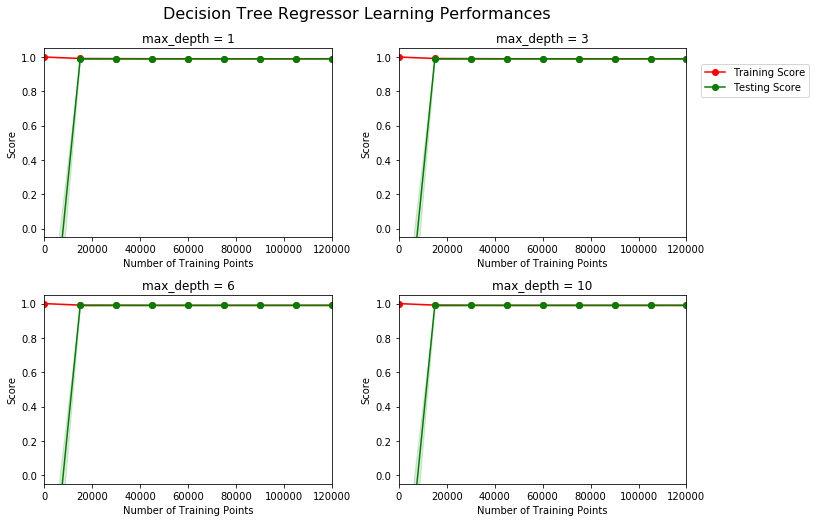

In [14]:
boosting_visuals.ModelLearning(X, y)

In [11]:
regressor_object = regressor.fit(X, y)
y_pred = regressor.predict(X)
score = regressor.score(X, y)

#### The decision path

> The decision path has been written to the file: logs\\Cost_Function_Trawling.log.txt within Notebook Folder.

In [12]:
file_object = open("logs\\Cost_Function_Trawling.log.txt", "a+")

output = io.StringIO()
output.write("Initial values of the predictor")
output.write(y[1:10].__str__())
output.write(y_pred[1:10].__str__() + "\n")
output.write("Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: ")
output.write(score.__str__() + "\n")
print("Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: ")
print(score.__str__() + "\n")
mse_gradient_booster = mean_squared_error(y, y_pred)
output.write("Gradient Boosting Regressor, MSE: ")
output.write(mse_gradient_booster.__str__() + "\n")
output.write("Gradient Boosting Regressor, MAE: ")
output.write(mean_absolute_error(y, y_pred).__str__() + "\n")

print("Gradient Boosting Regressor, MSE: ")
print(mse_gradient_booster.__str__() + "\n")
print("Gradient Boosting Regressor, MAE: ")
print(mean_absolute_error(y, y_pred).__str__() + "\n")

output.write("Regressor, Estimators: DecisionTreeClassifier: (The decision path)")
for estimator in regressor.estimators_:
    plot_decision_path.plot_decision_path(estimator[0], output)
file_object.write(output.getvalue())
output.close()
print("Output has been written to logs folder, Cost_Function.log.txt")

Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: 
0.990011694734

Gradient Boosting Regressor, MSE: 
84069287.1312

Gradient Boosting Regressor, MAE: 
1047.56350655

Output has been written to logs folder, Cost_Function.log.txt


In [13]:
file_object.flush()
file_object.close()

###### Method 1

Maximising the outcome by including specialty_weight as one of the X values, with y values also as specialty_weight

In [ ]:
# Fetching the pa_factors
z_safety = costfunction.get_safety_z_cost_function_maximised(0, 150000)

In [ ]:
X = np.array(z_safety['X'], dtype=np.dtype(np.float64))
y = np.array(z_safety['y'], dtype=np.dtype(np.int32))

In [9]:
from Plotting import boosting_visuals

In [10]:
boosting_visuals.ModelLearning(X, y)

In [12]:
regressor_object = regressor.fit(X, y)
y_pred = regressor.predict(X)
score = regressor.score(X, y)

#### The decision path

> The decision path has been written to the file: logs\\Cost_Function_Maximising.log.txt within Notebook Folder.

In [15]:
file_object = open("logs\\Cost_Function_Maximising.log.txt", "a+")

output = io.StringIO()
output.write("Initial values of the predictor")
output.write(y[1:10].__str__())
output.write(y_pred[1:10].__str__() + "\n")
output.write("Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: ")
output.write(score.__str__() + "\n")
print("Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: ")
print(score.__str__() + "\n")
mse_gradient_booster = mean_squared_error(y, y_pred)
output.write("Gradient Boosting Regressor, MSE: ")
output.write(mse_gradient_booster.__str__() + "\n")
output.write("Gradient Boosting Regressor, MAE: ")
output.write(mean_absolute_error(y, y_pred).__str__() + "\n")

print("Gradient Boosting Regressor, MSE: ")
print(mse_gradient_booster.__str__() + "\n")
print("Gradient Boosting Regressor, MAE: ")
print(mean_absolute_error(y, y_pred).__str__() + "\n")

output.write("Regressor, Estimators: DecisionTreeClassifier: (The decision path)")
for estimator in regressor.estimators_:
    plot_decision_path.plot_decision_path(estimator[0], output)
file_object.write(output.getvalue())
output.close()
print("Output has been written to logs folder, Cost_Function.log.txt")

Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: 
0.989897003941

Gradient Boosting Regressor, MSE: 
85034613.3749

Gradient Boosting Regressor, MAE: 
1048.37760044

Output has been written to logs folder, Cost_Function.log.txt


In [16]:
file_object.flush()
file_object.close()

##### Method 2

Optimizing the output by including the drug weight into the X values by keeping y values as Specialty Weight

In [15]:
# Fetching the pa_factors
z_safety = costfunction.get_safety_z_cost_function_optimized(0, 150000)

In [16]:
X = np.array(z_safety['X'], dtype=np.dtype(np.float64))
y = np.array(z_safety['y'], dtype=np.dtype(np.int32))

In [17]:
regressor_object = regressor.fit(X, y)
y_pred = regressor.predict(X)
score = regressor.score(X, y)

In [18]:
file_object = open("logs\\Cost_Function_Optimizing.log.txt", "a+")

output = io.StringIO()
output.write("Initial values of the predictor")
output.write(y[1:10].__str__())
output.write(y_pred[1:10].__str__() + "\n")
output.write("Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: ")
output.write(score.__str__() + "\n")
print("Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: ")
print(score.__str__() + "\n")
mse_gradient_booster = mean_squared_error(y, y_pred)
output.write("Gradient Boosting Regressor, MSE: ")
output.write(mse_gradient_booster.__str__() + "\n")
output.write("Gradient Boosting Regressor, MAE: ")
output.write(mean_absolute_error(y, y_pred).__str__() + "\n")

print("Gradient Boosting Regressor, MSE: ")
print(mse_gradient_booster.__str__() + "\n")
print("Gradient Boosting Regressor, MAE: ")
print(mean_absolute_error(y, y_pred).__str__() + "\n")

output.write("Regressor, Estimators: DecisionTreeClassifier: (The decision path)")
for estimator in regressor.estimators_:
    plot_decision_path.plot_decision_path(estimator[0], output)
file_object.write(output.getvalue())
output.close()
print("Output has been written to logs folder, Cost_Function_Optimizing.log.txt")

Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: 
0.989878362441

Gradient Boosting Regressor, MSE: 
85191514.6261

Gradient Boosting Regressor, MAE: 
1064.67192857

Output has been written to logs folder, Cost_Function_Optimizing.log.txt


In [19]:
file_object.flush()
file_object.close()

*** Getting all the data from the dataset of state 'Pennsylvania' ***

In [6]:
# Fetching the pa_factors
z_safety = costfunction.get_safety_z_cost_function_trawling(0, limit)

In [7]:
X = np.array(z_safety['X'], dtype=np.dtype(np.float64))
y = np.array(z_safety['y'], dtype=np.dtype(np.int32))

In [23]:
regressor_object = regressor.fit(X, y)
y_pred = regressor.predict(X)
score = regressor.score(X, y)

In [26]:
file_object = open("logs\\Cost_Function_FullDataset.log.txt", "a+")

output = io.StringIO()
output.write("Initial values of the predictor")
output.write(y[1:10].__str__())
output.write(y_pred[1:10].__str__() + "\n")
output.write("Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: ")
output.write(score.__str__() + "\n")
print("Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: ")
print(score.__str__() + "\n")
mse_gradient_booster = mean_squared_error(y, y_pred)
output.write("Gradient Boosting Regressor, MSE: ")
output.write(mse_gradient_booster.__str__() + "\n")
output.write("Gradient Boosting Regressor, MAE: ")
output.write(mean_absolute_error(y, y_pred).__str__() + "\n")

print("Gradient Boosting Regressor, MSE: ")
print(mse_gradient_booster.__str__() + "\n")
print("Gradient Boosting Regressor, MAE: ")
print(mean_absolute_error(y, y_pred).__str__() + "\n")

output.write("Regressor, Estimators: DecisionTreeClassifier: (The decision path)")
for estimator in regressor_object.estimators_:
    plot_decision_path.plot_decision_path(estimator[0], output)
file_object.write(output.getvalue())
output.close()
print("Output has been written to logs folder, Cost_Function_FullDataset.log.txt")

Gradient Boosting Regressor Algorithm Score (R2 Score): The concept of Hierarchical Specialty: 
0.971235726988

Gradient Boosting Regressor, MSE: 
234465955.36

Gradient Boosting Regressor, MAE: 
2743.50762408

Output has been written to logs folder, Cost_Function_FullDataset.log.txt


In [27]:
file_object.flush()
file_object.close()

In [ ]:
# Gradient Boosting regressor
regressor_object.apply(X)

*** The pickle objects relating to the decision tree parameters have been written to Notebook Folder ***

----------------------------

In [10]:
boosting_visuals.ModelComplexity(X, y)

*** The best rule filters for the DecisionTreeRegressors of the evaluation of Safety for Specialty Weights have been found to be: (These rule filters are comparison filters for the Optimizer Algorithm of the Safety vector; and the values are based on the log file found at logs\\Cost_Function_FullDataset.log (Backup).txt) ***

    - NPI Count
    - Drug Count
    - Day Supply

** The outcome of Gradient Boosting regression has proven that the Specialty weights and Drug weights devised are dependent only on Care, hence the comparison attributes chosen are from Care only **

*** The work of prescribing medications and alloting the claims to the Medicare is related to Growth models, whereas the decision making of prescribing medications is related to the Retention models ***

*** A suitable retention model to be selected is KMeans Algorithm ***

*** The comparison attributes assigned to the Latent Variables (Safety or Health) must be: ***

    - Supply per Claim
    
    - Ratio of the Specialty Std and Mean of Claim per Dollar (For, Solution for OPTIMISED CLAIM / DOSES)
    
    - Ratio of the Drug Mean and Std of Supply per Claim (For, Solution for DRUG FACILITY)
    
    - Termed as Health-wise Risk Ratio, Ratio of Total Claim Count and Drug Specific Claim Count 
    (For, Specialty Factor For Drug)
    
    - Beneficiary Risk (For, Drug Factor for Specialty)

In [17]:
from sklearn.cluster import KMeans

costfunction = CostFunction.CostFunction(database)

In [12]:
def database_get_health_lambda_cost_function(start, limit):
    return """
        SELECT claim_per_dollar, supply_per_claim, drug_mean_claim_per_dollar, 
        drug_mean_supply_per_claim, drug_std_claim_per_dollar,
        drug_std_supply_per_claim, drug_weight, specialty_weight, bene_risk, 
        IF(medicare_prvdr_enroll_status = 'E', 1, 0) as enroll_status, npi_claim_count,
        """ + partition.state + """_specialty_entropy.median_count,
        IF(drug_state_category = 'opioid', pa_cost_function.opioid, 
        IF(drug_state_category = 'antibiotic', pa_cost_function.antibiotic, 
        IF(drug_state_category = 'antipsychotic', pa_cost_function.antipsychotic, 
        IF(drug_state_category = 'HRM', pa_cost_function.hrm, 
        pa_cost_function.generic)))) as health_risk_ratio
        FROM """ + partition.state + """_cost_function
        INNER JOIN claim_aggregates.""" + partition.state + """_specialty_entropy
        ON """ + partition.state + """_specialty_entropy.specialty_description 
        = """ + partition.state + """_cost_function.specialty_description
        ORDER BY 
        supply_per_claim, (drug_mean_supply_per_claim / drug_std_supply_per_claim),
        (IF(drug_state_category = 'opioid', pa_cost_function.opioid, 
        IF(drug_state_category = 'antibiotic', pa_cost_function.antibiotic, 
        IF(drug_state_category = 'antipsychotic', pa_cost_function.antipsychotic, 
        IF(drug_state_category = 'HRM', pa_cost_function.hrm, 
        pa_cost_function.generic)))))
        LIMIT {0},{1}
        """.format(start, limit)

def get_specialty_factor_drug_cost_function(start, limit):
        return """
            SELECT specialty_factor_drug FROM """ + partition.state + """_cost_function
            ORDER BY 
            supply_per_claim, (drug_mean_supply_per_claim / drug_std_supply_per_claim),
            (IF(drug_state_category = 'opioid', pa_cost_function.opioid, 
            IF(drug_state_category = 'antibiotic', pa_cost_function.antibiotic, 
            IF(drug_state_category = 'antipsychotic', pa_cost_function.antipsychotic, 
            IF(drug_state_category = 'HRM', pa_cost_function.hrm, 
            pa_cost_function.generic)))))
            LIMIT {0},{1}
            """.format(start, limit)

def get_health_lambda_cost_function(start, limit):
        result = {'X': [], 'y': []}
        cursor = database.opt_connection.cursor()
        cursor.execute(database_get_health_lambda_cost_function(start, limit))
        X = cursor.fetchall()
        for item in X:
            result['X'].append(list(item))
        cursor.close()

        cursor = database.opt_connection.cursor()
        cursor.execute(get_specialty_factor_drug_cost_function(start, limit))
        y = cursor.fetchall()
        for item in y:
            result['y'].append(item[0])
        cursor.close()
        return result

In [21]:
z_safety = get_health_lambda_cost_function(0, 150000)
X = np.array(z_safety['X'], dtype=np.dtype(np.float64))
y = np.array(z_safety['y'])

In [22]:
kmeans = KMeans(n_clusters=50, n_jobs=-1)
kmeans_y_pred = kmeans.fit_predict(X)
score = kmeans.score(X)

In [23]:
print("KMeans score for the Z Vector: ")
print(score)

KMeans score for the Z Vector: 
-145759428183.0


In [7]:
def database_get_safety_lambda_cost_function(start, limit):
    return """
        SELECT cost_per_claim, supply_per_claim, 
        specialty_mean_cost_per_claim, specialty_mean_supply_per_claim, 
        specialty_std_cost_per_claim,
        specialty_std_supply_per_claim, drug_weight, specialty_weight, bene_risk,
        IF(drug_state_category = 'opioid', 2, IF(drug_state_category = 'antibiotic', 3, 
        IF(drug_state_category = 'antipsychotic', 4, IF(drug_state_category = 'HRM', 5, 1)))) as risk_weight, 
        agg_cost_part_d, med_bene_count
        FROM """ + partition.state + """_cost_function
        ORDER BY 
        supply_per_claim, 
        (specialty_std_claim_per_dollar/specialty_mean_claim_per_dollar),
        bene_risk
        LIMIT {0},{1}
        """.format(start, limit)

def get_drug_factor_specialty_cost_function(start, limit):
    return """
        SELECT drug_factor_specialty FROM """ + partition.state + """_cost_function
        ORDER BY 
        supply_per_claim, 
        (specialty_std_claim_per_dollar/specialty_mean_claim_per_dollar),
        bene_risk
        LIMIT {0},{1}
        """.format(start, limit)

def get_safety_lambda_cost_function(start, limit):
    result = {'X': [], 'y': []}
    cursor = database.opt_connection.cursor()
    cursor.execute(database_get_safety_lambda_cost_function(start, limit))
    X = cursor.fetchall()
    for item in X:
        result['X'].append(list(item))
    cursor.close()

    cursor = database.opt_connection.cursor()
    cursor.execute(get_drug_factor_specialty_cost_function(start, limit))
    y = cursor.fetchall()
    for item in y:
        result['y'].append(item[0])
    cursor.close()
    return result

In [18]:
limit = 18446744073709551615
lambda_safety = get_safety_lambda_cost_function(0, 150000)
X = np.array(lambda_safety['X'], dtype=np.dtype(np.float64))

In [10]:
y = np.array(lambda_safety['y'])
kmeans = KMeans(n_clusters=100, n_jobs=-1)
safety_lambda_kmeans_y_pred = kmeans.fit_predict(X)

In [19]:
score = kmeans.score(lambda_safety['X'])

In [20]:
print("KMeans score for the Lambda Vector: ")
print(score)

KMeans score for the Lambda Vector: 
-7.6491163062e+14


**The Specialty Weight and the Drug Weight are Control Metrics, so hence the Conjugate Gradient Method, as there is limited knowledge about these factors and it is best to go with conjugate directions.**

**The Drug Factor Specialty is Formulaic, so hence the Limited BFGS Algorithm, to take control of probabilistic as well as Quasi Newton characteristics**